In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [18]:
from scipy.special import roots_jacobi
from scipy.special import comb
# Algorithm Compute_binomial_coefficients
# Input : N
# Output: all binomial coefficients binom(n, j) for j=0,..,n, for n=0,...,N 
def Compute_binomial_coefficients(N):
    # compute all binomial coefficients
    Cb = []
    for n in range(0,N+1):
        c = []
        for j in range(n+1):
            c.append(comb(n,j))
        Cb.append(c)
    return Cb

# Algorithm Convective1d
# Input : K, n
# Output: local convective matrix using polynmials of degree n
#         int_K B_j^{n}(x) * d/dx B_i^{n}(x) dx
def Convective1d(K, n):
    # Compute convective matrix 
    if n == 0:
        return np.zeros((n+1,n+1), dtype=np.float64) 
    d = 1
    # grad \lambda_k = - |\gamma_k|/(d|K|) n_{K}
    hK = abs(K[1]-K[0])
    gradlambda = [-1.0/hK, 1.0/hK]
    mutilde = np.zeros((2*n-2+2,d+1))
    muA = Compute_mu(K, 2*n-1)
    for l in range(0, d+1):
        mutilde[:,l] = muA*gradlambda[l]
    B = np.zeros((n+1,n+1), dtype=np.float64)
    for alpha0 in range(0,n+1):
        for beta0 in range(0,n):
            w0 = Cb[alpha0+beta0][alpha0]/Cb[2*n-1][n-1] #comb(alpha0+beta0, alpha0)/comb(2*n-1, n-1)
            w1 = w0*Cb[(n)-alpha0 + (n-1)-beta0][(n)-alpha0] #w0*comb((n-1)-alpha0+(n)-beta0, (n-1)-alpha0)
            for l in range(0,d+1):
                B[alpha0,beta0+l] += n*w1*mutilde[alpha0+beta0,l]
    return B

# Algorithm Mass1d
# Input : K, n, c
# Output: local mass matrix using polynmials of degree n
#         int_K B_j^{n}(x) * c(x) * B_i^{n}(x) dx
def Mass1d(K, n, c):
    d = 1
    mu = Compute_mu(K, 2*n,c)
    M = np.zeros((n+1,n+1), dtype=np.float64)
    for alpha0 in range(0,n+1):
        for beta0 in range(0,n+1):
            w0 = Cb[alpha0+beta0][alpha0]/Cb[2*n][n] #comb(alpha0+beta0, alpha0)/comb(2*n, n)
            w1 = w0*Cb[(n)-alpha0 + (n)-beta0][(n)-alpha0]#w0*comb((n)-alpha0+(n)-beta0, (n)-alpha0)
            M[alpha0,beta0] += w1*mu[alpha0+beta0]
    return M

# Algortihm  Compute_mu
# Input : element K, n, f
# Output: Bernstein Bezier moments of degree n of a funcion f
from math import ceil
def Compute_mu(K, n, f=None, q=None):
    # compute the Bernstein Bezier moments of a function f
    # dimension
    d = 1
    # number of quadrature points
    if q is None or q <= 0.5*(n+1):
        q = ceil(0.5*(n+1))
    
    if f is None:
        F0 = np.ones(q)
        mu = abs(K[1]-K[0])/d*Moment(F0,q,n)
    else:
        # Gauss-Jacobi points
        xiv, omegav = roots_jacobi(q, alpha=0, beta=0, mu=False)
        # transformation from (-1,1) to K = (a,b)
        xK = 0.5*(K[0]*(1-xiv) + K[1]*(1+xiv))
        mu = abs(K[1]-K[0])/d*Moment(f(xK), q,n)
    return mu

# Algorithm Moment(F0, q)
# Input : Array F0 corresponding to values of a function f at Stroud nodes
# Output: Array Fd composed of Bernstein-Bezier moments of f using Stroud rule
def Moment(F0, q,n):
    d = 1
    Fnew = F0.copy()
    for l in range(1, d+1):
        Fold = Fnew
        Fnew = MomentStep(Fold, l, q,n)
    return Fnew


# Algorithm MomentStep(Fin, l, q)
# Input : Array Fin and index l in {1,...,d}
# Output: Updated array Fout with index il switched to alphal
def MomentStep(Fin, l, q, n):
    xiv, omegav = roots_jacobi(q, alpha=0, beta=0, mu=False)
    xiv += 1.0
    xiv *= 0.5
    omegav *= 0.5
    
    Fout = np.zeros(n+1)
    for il in range(0,q):
        xi    = xiv[il]
        omega = omegav[il]
        s     = 1-xi
        r     = xi/s
        w = omega*s**n
        for alphal in range(0, n+1):
            Fout[alphal] += w*Fin[il]
            w *= r*(n-alphal)/(1+alphal)
    return Fout

# Algorithm for interpolation
def NewtonBernstein(f, x=None):
    n = f.size-1
    if x is None:
        x = np.linspace(0, 1, n+1, endpoint=True)

    c = np.zeros(n+1, dtype = np.float64)
    w = np.zeros(n+1, dtype = np.float64)

    c[0] = f[0]
    w[0] = 1.0
    for s in range(1,n+1):
        for k in range(n, s-1, -1):
            f[k] = (f[k]-f[k-1])/(x[k]-x[k-s])
        for k in range(s, 0,-1):
            w[k] = (k/s)*w[k-1]*(1-x[s-1]) - (1-k/s)*w[k]*x[s-1]
            c[k] = (k/s)*c[k-1] + (1-k/s)*c[k] + f[s]*w[k]
        w[0] = -w[0]*x[s-1]
        c[0] = c[0] + f[s]*w[0]
    return c

def de_casteljau(t, coefs, t0=0.0, tf=1.0):
    beta = [c for c in coefs] # values in this list are overridden
    n = len(beta)
    for j in range(1, n):
        for k in range(n - j):
            # beta[k] = beta[k] * (tf - t)/(tf - t0) + beta[k + 1] * (t - t0)/(tf - t0)
            beta[k] = beta[k] * (tf - t) + beta[k + 1] * (t - t0)
    return beta[0]

In [6]:
def Compute_HDG_p( c, f, uhat = np.array([0,0]), p=2 ):
    
    # Local Matrices
    global Cb 
    Cb = Compute_binomial_coefficients(max(2*p,p))
    
    K = np.array([-1.0,1.0], dtype=np.float64)
    Bi = Convective1d(K, p)
    Mi = Mass1d(K, p, c)
    Si = np.zeros((p+1,p+1)); Si[0,0] = 1.0; Si[p,p] = 1.0
    Ei = np.zeros((2,p+1))  ; Ei[0,0] = 1.0; Ei[1,p] = 1.0
    Ci = np.zeros((2,p+1))  ; Ci[0,0] = -1.0; Ci[1,p] = 1.0
    Gi = np.eye(2)

    # Local load vector
    Fi = Compute_mu(K, p, f)
    # condensation
    Qp = np.vstack(( np.hstack(( Mi, -Bi.T)),  np.hstack(( Bi, Si)) ))
    CEi = np.hstack(( Ci, Ei ))
    R = np.linalg.solve(Qp, np.vstack(( Ci.T, -Ei.T )))
    Ai =  -CEi @ R - Gi
    Rb = np.linalg.solve(Qp, np.hstack((np.zeros(p+1), Fi )))
    bi = -CEi @ Rb

    qu = Rb-R.dot(uhat)
    qh = qu[0:(p+1)]
    uh = qu[(p+1):2*(p+1)]

    return uh, qh

In [ ]:
def plot_hdg1d(mesh, p, qh, uh, uhat, u, q):
    plt.rc('text', usetex=True)
    fig, ax = plt.subplots(2,1,figsize=(10, 14))
    # uhat and uh plot
    line_uhat,=ax[0].plot(mesh.Coordinates, uhat, color='C1',marker='o', markersize = 6, linestyle='None', label=r'$\widehat{u}$')
    dof = [(p+1), (p+1) -1]
        xx = mesh.Coordinates[mesh.Elements[j,:]]
        line_uh, = ax[0].plot(xx, uh[dof], color='C2')
    line_uh.set_label(r'$u_h$')
    xplot = np.linspace(mesh.Coordinates[0],mesh.Coordinates[-1],200)
    line_uexac = ax[0].plot(xplot, u(xplot), 'C3--', label = r'$u$ exact')
    ax[0].legend(loc='upper right', prop={'size': 18})

    # qh plot
    for j in range(mesh.NE):
        dof = [j*(p+1), (j+1)*(p+1) -1]
        xx = mesh.Coordinates[mesh.Elements[j]]
        line_qh, = ax[1].plot(xx, qh[dof], color='C0')
    line_qh.set_label(r'$q_h$')
    line_qexac = ax[1].plot(xplot, q(xplot), 'C3--', label = r'$q$ exact')
    ax[1].legend(loc='upper right',prop={'size': 18})
    
    plt.show()    

In [7]:
c = lambda x: 1.0+0*x
f = lambda x: 0*x + 2.0
uh, qh = Compute_HDG_p( c, f, uhat = np.array([0,0]), p=2 )

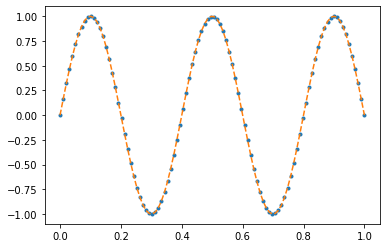

In [16]:
xx = np.linspace(0,1,15)
fun = lambda x: np.sin(5*np.pi*x)
fvals = fun(xx)
fBern = NewtonBernstein(fvals)

xplot = np.linspace(0,1,100)
fplot = [de_casteljau(t, fBern) for t in xplot]
plt.plot(xplot, fplot, '.')
plt.plot(xplot, fun(xplot), '--')
plt.show()

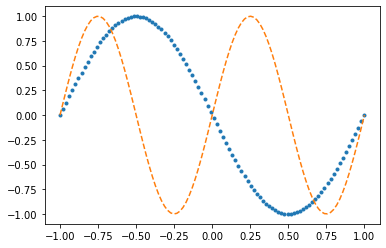

In [24]:
xx = np.linspace(-1,1,15)
fun = lambda x: np.sin(2*np.pi*x)
fvals = fun(xx)
fBern = NewtonBernstein(fvals, xx)

xplot = np.linspace(-1,1,100)
fplot = [de_casteljau(t, fBern, t0=-1, tf=1) for t in xplot]
plt.plot(xplot, fplot, '.')
plt.plot(xplot, fun(xplot), '--')
plt.show()